In [1]:
%load_ext autoreload
%autoreload 2
import re

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


import tasks.postprocessing
import tasks.constants
import tasks.graphs
import tasks.stats


tqdm.pandas()

In [2]:
VMAX = 0.2
VMIN = -0.2

## Load datasets

In [3]:
main_df = tasks.postprocessing.get_main_dataset()
main_df = main_df.iloc[:, [0, 1, 9, 4]]
main_df = main_df.drop_duplicates("message_id")
main_df["turns"] = "random_weighted"
main_df["prompts"] = "Original"
# remove seed comments from analysis
main_df = main_df[main_df.model != "hardcoded"]
main_df

,conv_id,message_id,message,model,turns,prompts
11,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,"@SkepticalInvestor77, you're missing the point...",Mistral Nemo (abl.),random_weighted,Original
22,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1583336252148959998,"@CitySlicker05, thank you for clarifying your ...",Mistral Nemo (abl.),random_weighted,Original
33,3bd075d6-b91b-4f60-9138-c33feff56d2c,838628372202429525,"@SkepticalInvestor77, I understand your perspe...",Mistral Nemo (abl.),random_weighted,Original
44,3bd075d6-b91b-4f60-9138-c33feff56d2c,1852804548951377081,"@GentleTherapist56, thank you for your thought...",Mistral Nemo (abl.),random_weighted,Original
55,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1794484532174709680,"@GentleTherapist56, you're reaching for the mo...",Mistral Nemo (abl.),random_weighted,Original
...,...,...,...,...,...,...
57266,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1972079638350772560,"@WanderlustNomad22, thank you for bringing up ...",Qwen 2.5,random_weighted,Original
57277,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1183976761754781031,I completely agree that addressing systemic is...,Qwen 2.5,random_weighted,Original
57288,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1769825593077317243,"@NatureLover88, thank you for sharing your per...",Qwen 2.5,random_weighted,Original
57299,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1394900428090388415,"@NatureLover88, I totally agree with you about...",Qwen 2.5,random_weighted,Original


In [4]:
abl_df = tasks.postprocessing.get_ablation_df()
abl_df = abl_df.loc[
    :, ["conv_id", "message_id", "message", "turns", "prompts"]
]
abl_df.turns = np.where(
    abl_df.turns.apply(lambda x: str(x) == "nan"),
    "random_weighted",
    abl_df.turns,
)
abl_df.prompts = np.where(
    abl_df.prompts.apply(lambda x: str(x) == "nan"), "original", abl_df.prompts
)
abl_df["model"] = "Qwen 2.5"
abl_df

,conv_id,message_id,message,turns,prompts,model
0,e9001267-fba5-4e81-9340-10256439f896,-618891699449759534,How do you know he is not proud of his cakes? ...,random_weighted,noroles,Qwen 2.5
1,e9001267-fba5-4e81-9340-10256439f896,-300876236281035132,"@SurvivalistHunter65 Okay, first off, let’s be...",random_weighted,noroles,Qwen 2.5
2,e9001267-fba5-4e81-9340-10256439f896,-136774720061539955,NaN,random_weighted,noroles,Qwen 2.5
3,e9001267-fba5-4e81-9340-10256439f896,-170339060548748661,"@SurvivalistHunter65, @RebelliousTeen44, let's...",random_weighted,noroles,Qwen 2.5
4,e9001267-fba5-4e81-9340-10256439f896,-90638422715427188,"@RebelliousTeen44, @OptimisticNurse42 Thanks f...",random_weighted,noroles,Qwen 2.5
...,...,...,...,...,...,...
1461,86f6b244-2f63-40f1-87dc-11eb6e4e0862,1269456098477038129,NaN,random,original,Qwen 2.5
1462,86f6b244-2f63-40f1-87dc-11eb6e4e0862,2099748626367877414,@MysteriousArtist34 That's beautiful. Art and ...,random,original,Qwen 2.5
1463,86f6b244-2f63-40f1-87dc-11eb6e4e0862,1269456098477038129,NaN,random,original,Qwen 2.5
1464,86f6b244-2f63-40f1-87dc-11eb6e4e0862,-1492233235653878353,"@NatureLover88 Absolutely, I couldn't agree mo...",random,original,Qwen 2.5


Data from CeRI http://archive.regulationroom.org/

Any opinions, findings, and conclusions or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the CeRI (Cornell e-Rulemaking Initiative).

In [5]:
human_df = tasks.postprocessing.get_human_df()
human_df["model"] = "Human"
human_df["turns"] = "Human"
human_df["prompts"] = "Human"

human_df

,conv_id,message_id,message,model,turns,prompts
0,What counts as texting,249.0,You probably ought to explicitly call out the ...,Human,Human,Human
1,What are the risks?,250.0,I would be interested in knowing why the DOT d...,Human,Human,Human
2,What counts as texting,251.0,I don't believe that entering a phone number o...,Human,Human,Human
3,What are the risks?,252.0,"Personally, I don't think there should be a la...",Human,Human,Human
4,What are the risks?,253.0,\t\t\t\t_x000D_\t\t\t\tWelcome to Regulation R...,Human,Human,Human
...,...,...,...,...,...,...
3644,"Roads & bridges: Repair, restoration, moderniz...",288.0,Just because the Move NY FAIR Plan has the wor...,Human,Human,Human
3645,Bus: More express bus and Select Bus service; ...,289.0,The proposed SBS project for Woodhaven Blvd in...,Human,Human,Human
3646,Dealing with Transportation Deserts: Full-feat...,290.0,Thanks for letting us know - we fixed the mist...,Human,Human,Human
3647,"Roads & bridges: Repair, restoration, moderniz...",291.0,"Hi rickhoran, Welcome to the discussion and th...",Human,Human,Human


In [6]:
df = pd.concat([main_df, abl_df, human_df], ignore_index=True)
df

,conv_id,message_id,message,model,turns,prompts
0,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,"@SkepticalInvestor77, you're missing the point...",Mistral Nemo (abl.),random_weighted,Original
1,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1583336252148959998,"@CitySlicker05, thank you for clarifying your ...",Mistral Nemo (abl.),random_weighted,Original
2,3bd075d6-b91b-4f60-9138-c33feff56d2c,838628372202429525,"@SkepticalInvestor77, I understand your perspe...",Mistral Nemo (abl.),random_weighted,Original
3,3bd075d6-b91b-4f60-9138-c33feff56d2c,1852804548951377081,"@GentleTherapist56, thank you for your thought...",Mistral Nemo (abl.),random_weighted,Original
4,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1794484532174709680,"@GentleTherapist56, you're reaching for the mo...",Mistral Nemo (abl.),random_weighted,Original
...,...,...,...,...,...,...
8541,"Roads & bridges: Repair, restoration, moderniz...",288.0,Just because the Move NY FAIR Plan has the wor...,Human,Human,Human
8542,Bus: More express bus and Select Bus service; ...,289.0,The proposed SBS project for Woodhaven Blvd in...,Human,Human,Human
8543,Dealing with Transportation Deserts: Full-feat...,290.0,Thanks for letting us know - we fixed the mist...,Human,Human,Human
8544,"Roads & bridges: Repair, restoration, moderniz...",291.0,"Hi rickhoran, Welcome to the discussion and th...",Human,Human,Human


In [7]:
df.message = df.message.astype(str)
df.message = np.where(df.message == "nan", "", df.message)
# rename values for graphs
df.turns = df.turns.map(
    {
        "roundrobin": "Round Robin",
        "random": "Random",
        "random_weighted": "Random Weighted",
        "Human": "Human",
        "Original": "Original",
    }
)
df.prompts = df.prompts.map(
    {
        "nosdb": "No SDBs",
        "basicinstructions": "Basic Instructions",
        "original": "Original",
        "Original": "Original",
        "noroles": "No roles",
        "Human": "Human",
    }
)
df
df = df.rename(
    {
        "turns": "Turn taking function",
        "prompts": "Instruction prompt",
        "model": "Model",
    },
    axis=1,
)
df

,conv_id,message_id,message,Model,Turn taking function,Instruction prompt
0,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,"@SkepticalInvestor77, you're missing the point...",Mistral Nemo (abl.),Random Weighted,Original
1,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1583336252148959998,"@CitySlicker05, thank you for clarifying your ...",Mistral Nemo (abl.),Random Weighted,Original
2,3bd075d6-b91b-4f60-9138-c33feff56d2c,838628372202429525,"@SkepticalInvestor77, I understand your perspe...",Mistral Nemo (abl.),Random Weighted,Original
3,3bd075d6-b91b-4f60-9138-c33feff56d2c,1852804548951377081,"@GentleTherapist56, thank you for your thought...",Mistral Nemo (abl.),Random Weighted,Original
4,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1794484532174709680,"@GentleTherapist56, you're reaching for the mo...",Mistral Nemo (abl.),Random Weighted,Original
...,...,...,...,...,...,...
8541,"Roads & bridges: Repair, restoration, moderniz...",288.0,Just because the Move NY FAIR Plan has the wor...,Human,Human,Human
8542,Bus: More express bus and Select Bus service; ...,289.0,The proposed SBS project for Woodhaven Blvd in...,Human,Human,Human
8543,Dealing with Transportation Deserts: Full-feat...,290.0,Thanks for letting us know - we fixed the mist...,Human,Human,Human
8544,"Roads & bridges: Repair, restoration, moderniz...",291.0,"Hi rickhoran, Welcome to the discussion and th...",Human,Human,Human


### Comment length

In [8]:
len_df = df
len_df["comment_length"] = df.message.apply(lambda x: len(x.split()))

len_df.sort_values("comment_length", ascending=False).head(10)

,conv_id,message_id,message,Model,Turn taking function,Instruction prompt,comment_length
6072,What will this cost?,128.0,You mentioned that the government could subsid...,Human,Human,Human,1629
7698,Unlawful collection practices,1205.0,I am responding to the some of the questions p...,Human,Human,Human,1459
6757,For All Borrowers: Periodic Statements,297.0,The Periodic Statement is great and you can se...,Human,Human,Human,1270
8415,Bicycles; Pedestrians,162.0,I&#39;m going to say something critical and un...,Human,Human,Human,1248
6247,What will this cost?,313.0,Issue: US DOTâ€™s proposed rulemaking regardi...,Human,Human,Human,1238
7918,Unlawful collection practices,697.0,"As an identity theft victim, I have had dozens...",Human,Human,Human,1205
6773,"For All Borrowers: Asking For, and Getting, In...",315.0,"Moderator, why is the CFPB concerned about giv...",Human,Human,Human,1199
7739,Questions about phones & mobile phones in debt...,1366.0,Complaints:\nâ€¢\tThe Industry is allowed to p...,Human,Human,Human,1154
5347,peanut allergies,635.0,"As I understand it, the DOT considers peanut a...",Human,Human,Human,1119
5822,peanut allergies,505.0,In the late 1990â€™s the U.S. Department of T...,Human,Human,Human,1087


In [9]:
len_df.comment_length.describe()

count    8546.000000
mean       84.209455
std        94.885259
min         0.000000
25%        35.000000
50%        60.000000
75%       104.000000
max      1629.000000
Name: comment_length, dtype: float64

In [10]:
len_df.comment_length = len_df.comment_length.clip(lower=2, upper=400)

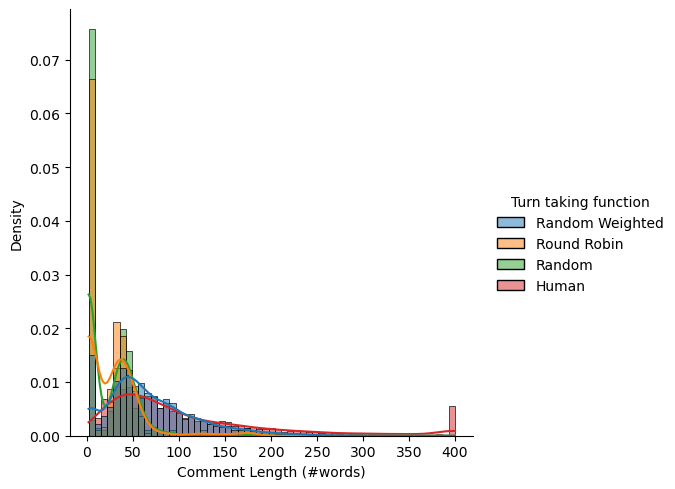

In [11]:
tasks.graphs.comment_len_plot(
    len_df, length_col="comment_length", feature_col="Turn taking function"
)

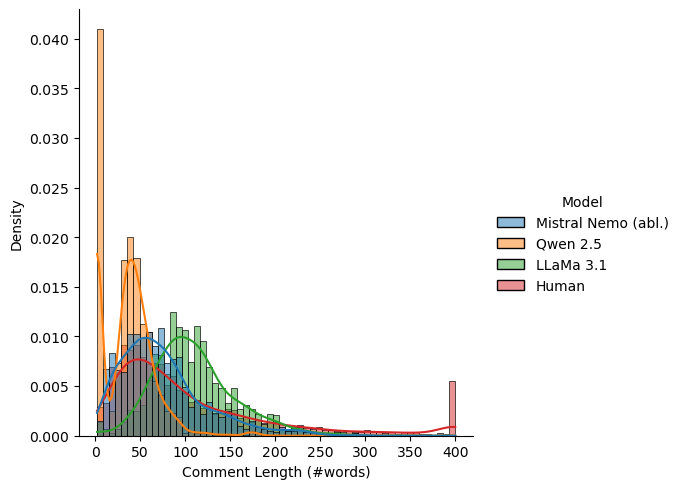

In [12]:
tasks.graphs.comment_len_plot(
    len_df, length_col="comment_length", feature_col="Model"
)

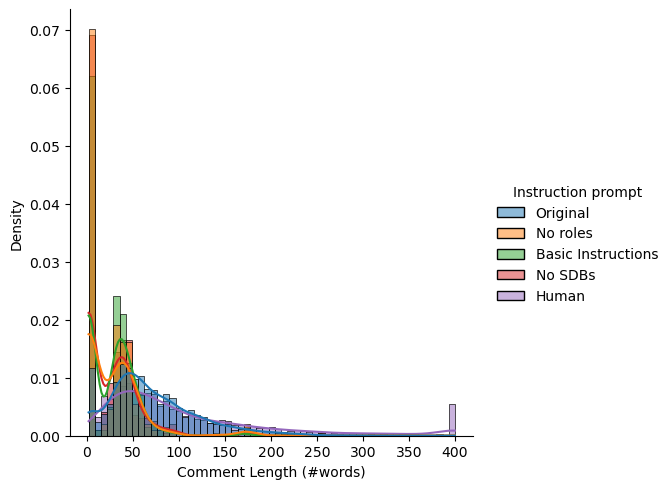

In [13]:
tasks.graphs.comment_len_plot(
    len_df, length_col="comment_length", feature_col="Instruction prompt"
)

### Diversity

In [14]:
similarity_df = df.copy()
# delete @ usernames
similarity_df.message = similarity_df.message.apply(
    lambda msg: " ".join(
        word for word in msg.split() if not word.startswith("@")
    )
)
similarity_df = (
    similarity_df.groupby(
        ["conv_id", "Model", "Instruction prompt", "Turn taking function"]
    )["message"]
    .apply(lambda messages: messages.tolist())
    .reset_index()
)
comments_ls = similarity_df["message"].tolist()
similarity_df["rougel_similarity"] = tasks.stats.rougel_similarity(comments_ls)
similarity_df = similarity_df[~similarity_df.rougel_similarity.isnull()]
similarity_df.rougel_similarity.describe()

Computing ROUGE-L similarities:   0%|          | 0/288 [00:00<?, ?it/s]

count    273.000000
mean       0.125093
std        0.063414
min        0.001060
25%        0.099085
50%        0.126230
75%        0.156113
max        0.750000
Name: rougel_similarity, dtype: float64

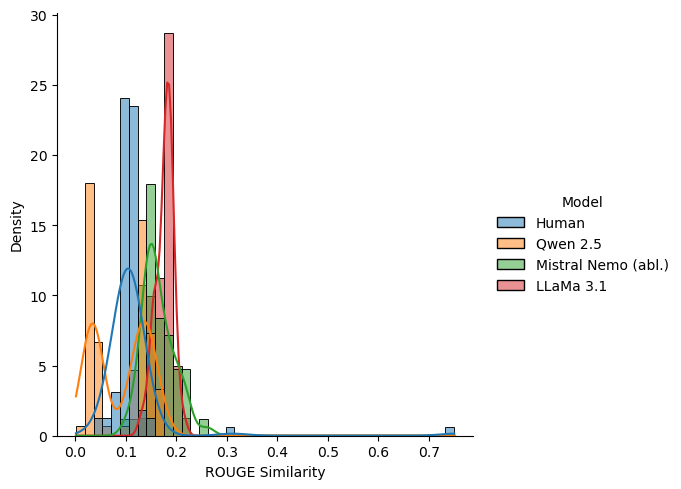

In [15]:
tasks.graphs.rougel_plot(
    df=similarity_df, rougel_col="rougel_similarity", feature_col="Model"
)

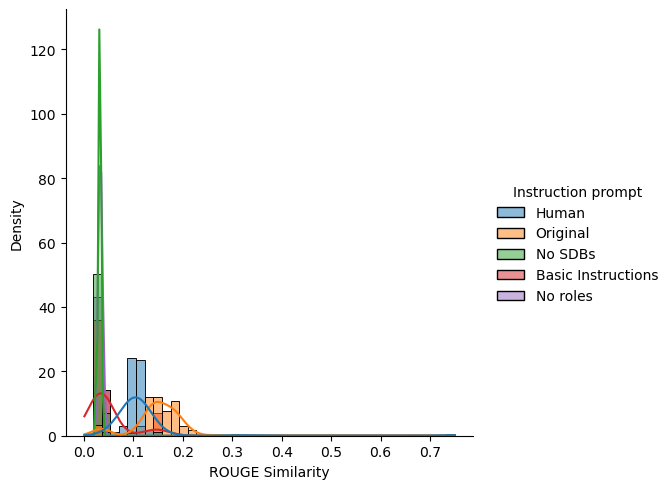

In [16]:
tasks.graphs.rougel_plot(
    df=similarity_df,
    rougel_col="rougel_similarity",
    feature_col="Instruction prompt",
)

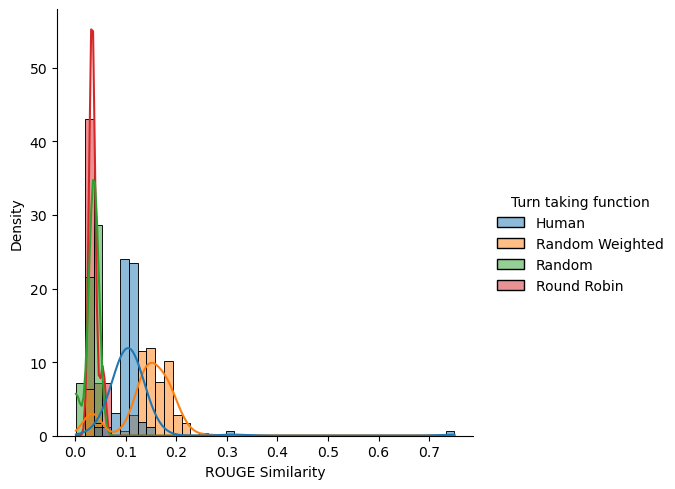

In [17]:
tasks.graphs.rougel_plot(
    df=similarity_df,
    rougel_col="rougel_similarity",
    feature_col="Turn taking function",
)

## Statistical tests

In [18]:
tasks.stats.mean_comp_test(
    df=similarity_df, feature_col="Model", score_col="rougel_similarity"
)

6.215201933115157e-20

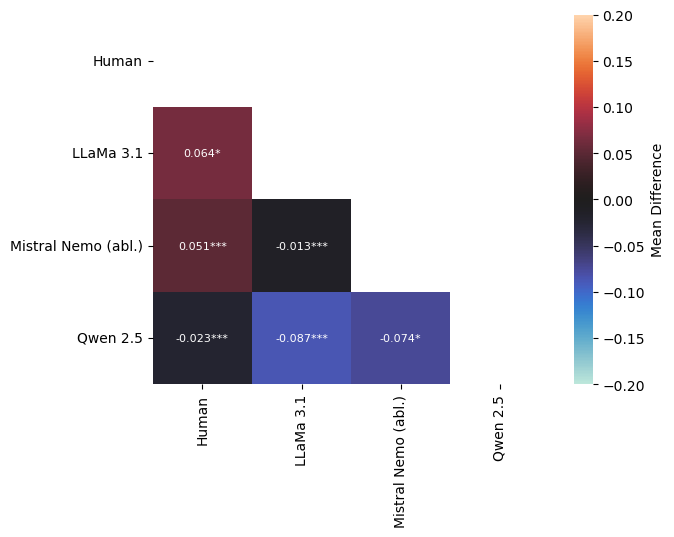

In [19]:
tasks.graphs.posthoc_dunn_heatmap(
    similarity_df, "rougel_similarity", group_col="Model", vmin=VMIN, vmax=VMAX
)

In [20]:
tasks.stats.mean_comp_test(
    df=similarity_df,
    feature_col="Instruction prompt",
    score_col="rougel_similarity",
)

1.8676834636658222e-15

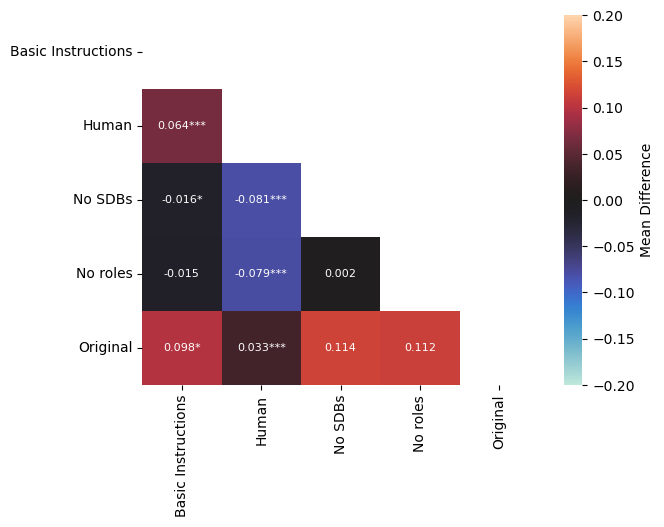

In [21]:
tasks.graphs.posthoc_dunn_heatmap(
    similarity_df,
    "rougel_similarity",
    group_col="Instruction prompt",
    vmin=VMIN,
    vmax=VMAX,
)

In [22]:
tasks.stats.mean_comp_test(
    df=similarity_df,
    feature_col="Turn taking function",
    score_col="rougel_similarity",
)

4.393654064104084e-11

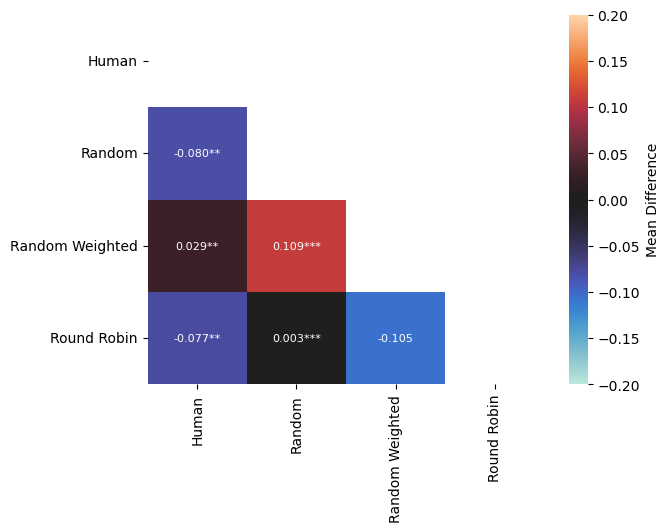

In [23]:
tasks.graphs.posthoc_dunn_heatmap(
    similarity_df,
    "rougel_similarity",
    group_col="Turn taking function",
    vmin=VMIN,
    vmax=VMAX,
)